In [18]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, accuracy_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rbf
import importlib

In [2]:
# Load the breast cancer dataset
data = load_breast_cancer()

# Convert to pandas DataFrame
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = (data.target == 0).astype(int)  # Binary target: 0 (malignant) -> 1, 1 (benign) -> 0

# Split the dataset into 70% training and 30% testing
X = df.drop(columns=['target'])
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Optionally, convert back to DataFrame after scaling
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

X_train.shape

(398, 30)

In [3]:
# Perform logistic regression
em_model = LogisticRegression()
em_model.fit(X_train, y_train)

# Compute the accuracy of the model
y_pred = em_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy

/Users/guilhermejose/Desktop/Machine-Learning/ml-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9707602339181286

In [4]:
# Perform Gaussian Mixture Model clustering
em_models = []
accuracies = []
for k in range(2, 11):
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(X_train)
    y_pred = gmm.predict(X_test)
    score = silhouette_score(X_test, y_pred)
    accuracies.append(score)
    em_models.append(gmm)


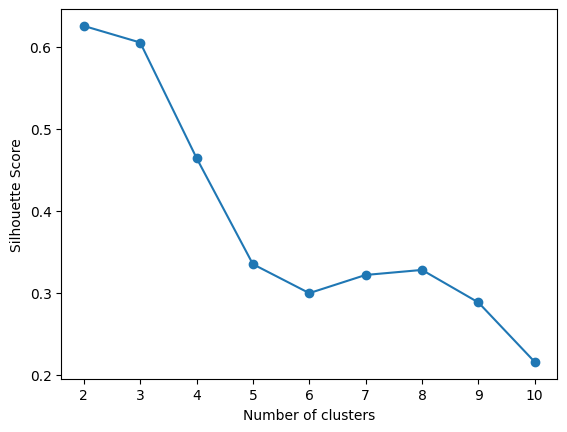

In [5]:
# Plot the silhoette results

plt.plot(range(2, 11), accuracies, marker='o')

plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

plt.show()

The number of clusters with the highest silhouette aligns perfectly with the problem. With a binary target variable we got k = 2 as the optimal number of clusters.

## Mapping the dataset into probability values
We are going to transform this dataset by mapping every observation in probability values for each of the 2 clusters.

In [6]:
# For every model, apply the transformation and store it
X_train_transformed = []
X_test_transformed = []
for em_model in em_models:
    X_train_transformed.append(em_model.predict_proba(X_train))
    X_test_transformed.append(em_model.predict_proba(X_test))

In [7]:
# Perform logistic regression on the transformed data
accuracies = []

for i in range(len(em_models)):
    model = LogisticRegression()
    model.fit(X_train_transformed[i], y_train)
    y_pred = model.predict(X_test_transformed[i])
    score = accuracy_score(y_test, y_pred)
    accuracies.append(score)

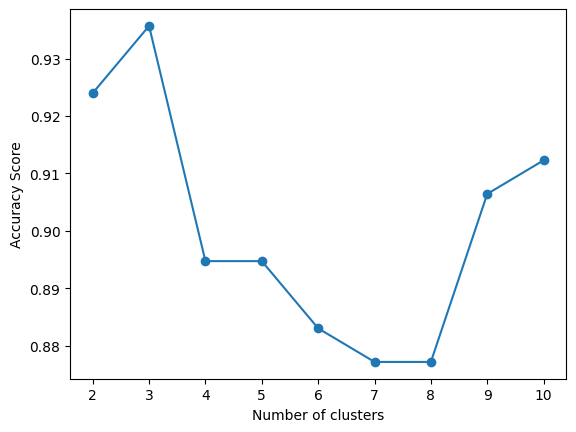

In [8]:
# Plot the accuracy scores against the number of clusters
plt.plot(range(2, 11), accuracies, marker='o')

plt.xlabel('Number of clusters')
plt.ylabel('Accuracy Score')

plt.show()

## RBF network with mapped dataset when k = 2

In [22]:
centers = em_models[0].means_

importlib.reload(rbf)

# Print X_train
print(X_train)

model = rbf.RBFNetwork(centers=centers, sigma=1)
model.fit(X_train, y_train)



     mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
149       13.740         17.91           88.12      585.0          0.07944   
124       13.370         16.39           86.10      553.5          0.07115   
421       14.690         13.98           98.22      656.1          0.10310   
195       12.910         16.33           82.53      516.4          0.07941   
545       13.620         23.23           87.19      573.2          0.09246   
..           ...           ...             ...        ...              ...   
71         8.888         14.64           58.79      244.0          0.09783   
106       11.640         18.33           75.17      412.5          0.11420   
270       14.290         16.82           90.30      632.6          0.06429   
435       13.980         19.62           91.12      599.5          0.10600   
102       12.180         20.52           77.22      458.7          0.08013   

     mean compactness  mean concavity  mean concave points  mea

In [ ]:
# Compute the accuracy
importlib.reload(rbf)
print(X_test.shape)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

     mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
204       12.470         18.60           81.09      481.9          0.09965   
70        18.940         21.31          123.60     1130.0          0.09009   
131       15.460         19.48          101.70      748.9          0.10920   
431       12.400         17.68           81.47      467.8          0.10540   
540       11.540         14.44           74.65      402.9          0.09984   
..           ...           ...             ...        ...              ...   
69        12.780         16.49           81.37      502.5          0.09831   
542       14.740         25.42           94.70      668.6          0.08275   
176        9.904         18.06           64.60      302.4          0.09699   
501       13.820         24.49           92.33      595.9          0.11620   
247       12.890         14.11           84.95      512.2          0.08760   

     mean compactness  mean concavity  mean concave points  mea

UFuncTypeError: ufunc 'subtract' did not contain a loop with signature matching types (dtype('<U11'), dtype('float64')) -> None